In [ ]:
# !pip install tensorflow-gpu==1.14.0

In [1]:
%load_ext autoreload
%autoreload 2

from classification_models.tfkeras import Classifiers
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

tf.enable_eager_execution()

keras = tf.keras
K = tf.keras.backend

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import iic_datasets_ops
import iic_loss_ops
import utils
import models
import mnist_ops

In [3]:
batch_size = 64
num_classes = 10
num_repeats = 2
input_shape = [28, 28, 1]

train_dataset, dataset_info = tfds.load(name="fashion_mnist", split=tfds.Split.TRAIN, as_supervised=True, with_info=True)
test_dataset = tfds.load(name="fashion_mnist", split=tfds.Split.TEST, as_supervised=True)

In [44]:
cls_sampled_dataset = iic_datasets_ops.sample_classification_dataset(train_dataset)

60000it [00:12, 4940.75it/s]


Found n=10 classes in dataset.
Number of classes after rejections is 10.
Selecting most distance examples from buffers


In [42]:
num_train_examples, num_test_examples = dataset_info.as_proto.splits[1].statistics.num_examples, dataset_info.as_proto.splits[0].statistics.num_examples 
num_train_steps = num_train_examples // batch_size
num_test_steps = num_test_examples // batch_size
num_train_examples, num_test_examples, num_train_steps, num_test_steps

(60000, 10000, 937, 156)

In [45]:
first_image_aug_fn = iic_datasets_ops.get_default_image_aug_fn(rotation=0.1, skew=0.05, translation=0.1, crop=0.2)
second_image_aug_fn = iic_datasets_ops.get_default_image_aug_fn(crop=0.2)

test_image_aug_fn = iic_datasets_ops.get_default_image_aug_fn(
    rotation=0.0, skew=0.0, translation=0.0, crop=0.3, hue=0.0, 
    saturation=0.0, brightness=0.0, uniform_noise=0.0, contrast=0.0
)


iic_train_dataset, model_input_shape = iic_datasets_ops.prepare_dataset(
    dataset=train_dataset,
    first_image_aug_fn=first_image_aug_fn,
    second_image_aug_fn=second_image_aug_fn,
    batch_size=batch_size,
    num_image_repeats=num_repeats,
    input_size=input_shape[:2],
)


iic_cls_train_dataset, _ = iic_datasets_ops.prepare_dataset(
    dataset=cls_sampled_dataset,
    first_image_aug_fn=first_image_aug_fn,
    second_image_aug_fn=second_image_aug_fn,
    batch_size=batch_size,
    num_image_repeats=num_repeats,
    input_size=input_shape[:2],
)

W1023 18:49:39.040354 139725959153472 deprecation_wrapper.py:119] From /media/INNE/FORNAX/deep-learning-notes/IIC/iic_datasets_ops.py:31: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1023 18:49:40.183276 139725959153472 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [46]:
iic_test_dataset, _ = iic_datasets_ops.prepare_dataset(
    dataset=test_dataset,
    first_image_aug_fn=test_image_aug_fn,
    second_image_aug_fn=test_image_aug_fn,
    batch_size=batch_size,
    num_image_repeats=num_repeats,
    input_size=input_shape[:2],
)

In [47]:
iic_train_dataset, iic_test_dataset

(<DatasetV1Adapter shapes: ({image: (?, 28, 28, 1), tf_image: (?, 28, 28, 1)}, {label: (?,)}), types: ({image: tf.float32, tf_image: tf.float32}, {label: tf.int64})>,
 <DatasetV1Adapter shapes: ({image: (?, 28, 28, 1), tf_image: (?, 28, 28, 1)}, {label: (?,)}), types: ({image: tf.float32, tf_image: tf.float32}, {label: tf.int64})>)

In [48]:
model_input_shape

[28, 28, 1]

In [49]:
iic_train_iterator = iic_train_dataset.make_one_shot_iterator()
iic_test_iterator = iic_test_dataset.make_one_shot_iterator()
iic_cls_train_iterator = iic_cls_train_dataset.make_one_shot_iterator()
iic_train_iterator, iic_test_iterator

(<tensorflow.python.data.ops.iterator_ops.IteratorV2 at 0x7f139edd2908>,
 <tensorflow.python.data.ops.iterator_ops.IteratorV2 at 0x7f139edd26a0>)

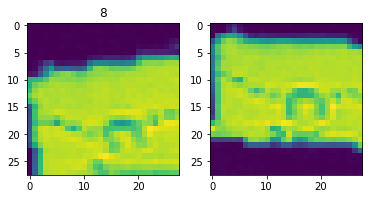

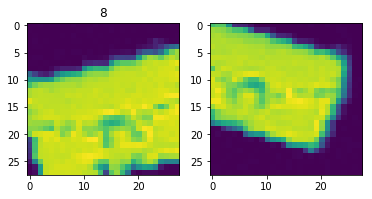

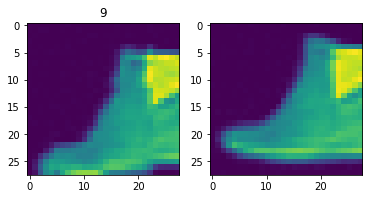

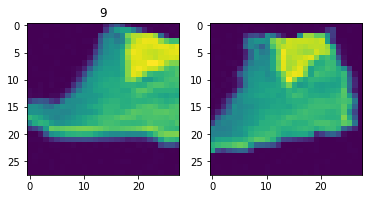

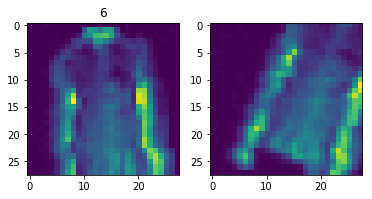

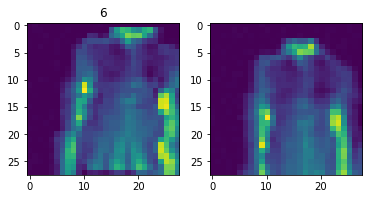

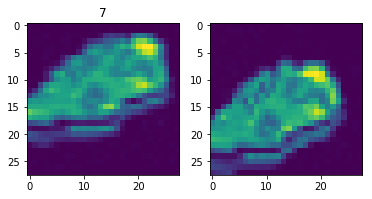

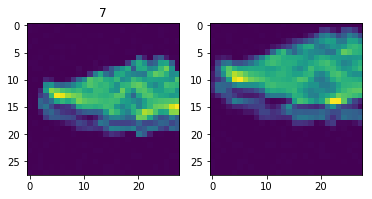

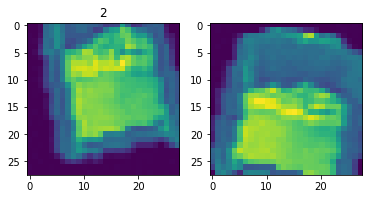

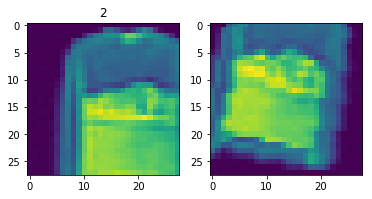

In [50]:
utils.plot_image_pairs(*next(iic_train_iterator), num_examples=10)

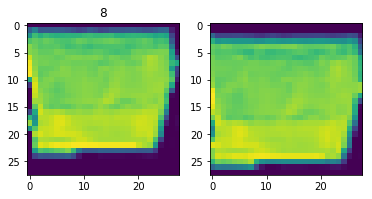

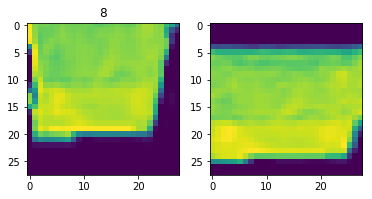

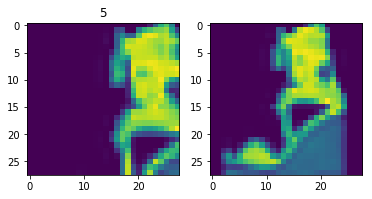

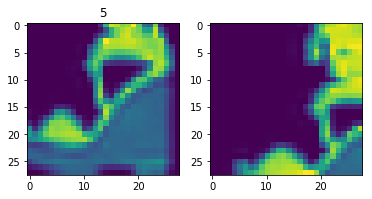

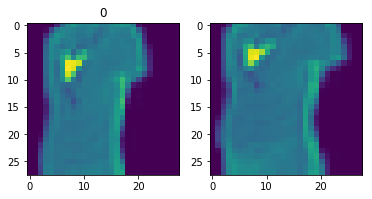

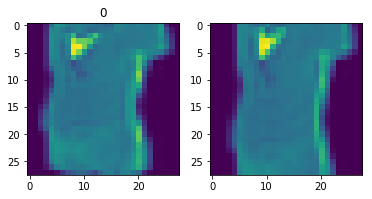

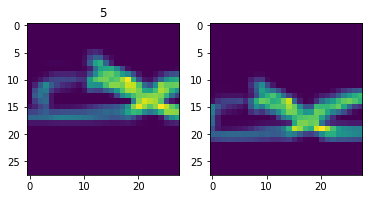

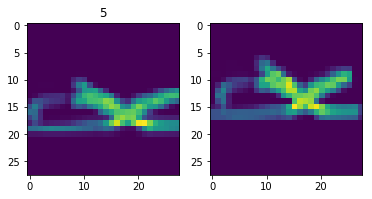

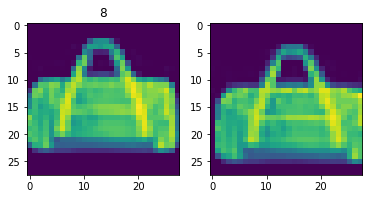

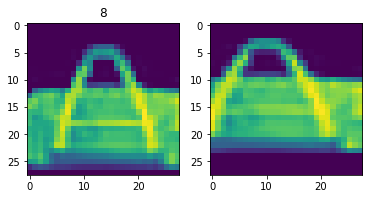

In [51]:
utils.plot_image_pairs(*next(iic_test_iterator), num_examples=10)

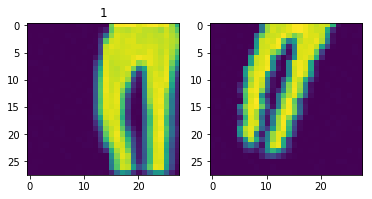

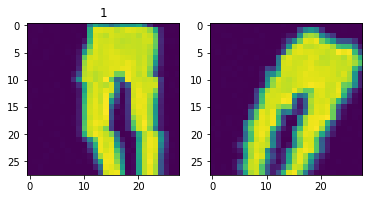

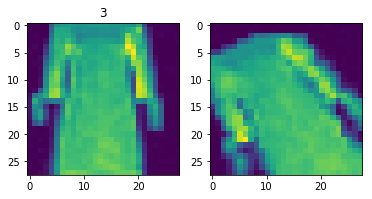

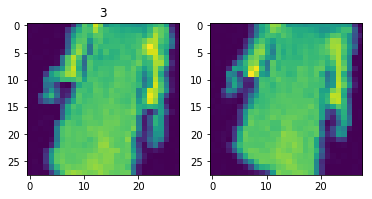

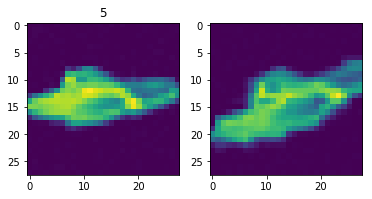

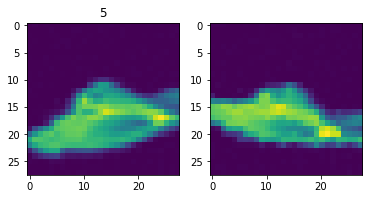

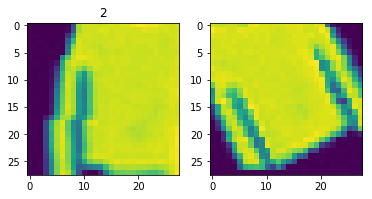

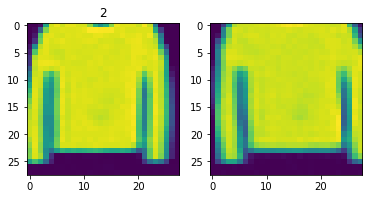

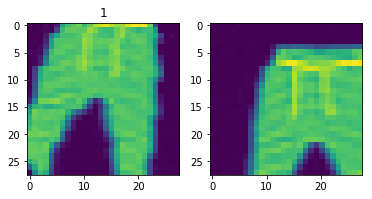

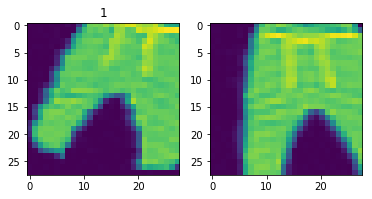

In [52]:
utils.plot_image_pairs(*next(iic_cls_train_iterator), num_examples=10)

In [54]:
%timeit -n 10 next(iic_train_iterator)

The slowest run took 52.56 times longer than the fastest. This could mean that an intermediate result is being cached.
12.5 ms ± 7.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


# Test standard classification using sampled classes

In [83]:
base_model = models.create_resnet_se_backbone(model_input_shape, (4, 4, 4))
iic_prediction_model = models.create_iic_model(
    base_model, 
    main_heads_num_classes=[num_classes], 
    aux_heads_num_classes=[],
)

image_input = keras.Input(shape=model_input_shape, name="image")
image_predictions = iic_prediction_model(image_input)
cls_labels = tf.keras.layers.Lambda(lambda x: x, name="label")(image_predictions['main_heads'][0])

standard_cls_model = keras.Model(
    inputs=image_input, 
    outputs=cls_labels
)

In [84]:
optimizer = keras.optimizers.Adam(learning_rate=0.0005)
standard_cls_model.compile(
    optimizer=optimizer, 
    loss={"label": "sparse_categorical_crossentropy"}, 
    metrics={"label": "accuracy"}
)

In [87]:
standard_cls_model.fit(
    iic_cls_train_dataset, verbose=1, epochs=1,
    steps_per_epoch=300, 
    callbacks=[
        utils.PredictionsHistory("test", standard_cls_model, iic_test_iterator, num_classes=num_classes),
        utils.PredictionsHistory("train", standard_cls_model, iic_cls_train_iterator, num_classes=num_classes)
    ]
)

W1023 20:00:16.001756 139725959153472 deprecation.py:323] From /home/mkk/anaconda3/envs/vision-tf1.12/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


160/300 [===============>..............] - ETA: 3:11 - loss: 0.6922 - acc: 0.8890

KeyboardInterrupt: 

In [88]:
def cls_dataset_test_generator():
    while True:
        f, l = iic_test_iterator.get_next()
        yield f['image'][::2], l['label'][::2]

In [89]:
standard_cls_model.evaluate(cls_dataset_test_generator(), steps=100)

100/100 [==============================] - 13s 126ms/step - loss: 2.5984 - acc: 0.2805


[2.598439700603485, 0.28046876]

# Combine standard classification with unsupervised loss

In [90]:
def remap_dataset(pair_data, cls_data):
    pair_data[0]['cls_image'] = cls_data[0]['image']
    return {
        "image": pair_data[0]['image'],
        "tf_image": pair_data[0]['tf_image'],
        "cls_image": cls_data[0]['image']
    }, cls_data[1]

combined_dataset = tf.data.Dataset.zip((iic_train_dataset, iic_cls_train_dataset)).map(remap_dataset)
combined_dataset

<DatasetV1Adapter shapes: ({image: (?, 28, 28, 1), tf_image: (?, 28, 28, 1), cls_image: (?, 28, 28, 1)}, {label: (?,)}), types: ({image: tf.float32, tf_image: tf.float32, cls_image: tf.float32}, {label: tf.int64})>

In [91]:
base_model = models.create_resnet_se_backbone(model_input_shape, (4, 4, 4))

In [92]:
base_model.summary()

Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 28, 28, 1)    3           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_78 (ZeroPadding2 (None, 34, 34, 1)    0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 14, 14, 64)   3136        zero_padding2d_78[0][0]          
___________________________________________________________________________________________

In [93]:
iic_prediction_model = models.create_iic_model(
    base_model, 
    main_heads_num_classes=[num_classes], 
    aux_heads_num_classes=[],
)

In [94]:
iic_prediction_model.summary()

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
model_19 (Model)             (None, 2, 2, 256)         5932467   
_________________________________________________________________
global_average_pooling2d_51  (None, 256)               0         
_________________________________________________________________
main_head_0/dense (Dense)    (None, 10)                2570      
_________________________________________________________________
main_head_0/p_out (Lambda)   (None, 10)                0         
Total params: 5,935,037
Trainable params: 5,927,611
Non-trainable params: 7,426
_________________________________________________________________


In [95]:
assert len(iic_prediction_model.outputs) == 1

In [96]:
image_input = keras.Input(shape=model_input_shape, name="image")
tf_image_input = keras.Input(shape=model_input_shape, name="tf_image")
cls_image_input = keras.Input(shape=model_input_shape, name="cls_image")

image_predictions = iic_prediction_model(image_input)
tf_image_predictions = iic_prediction_model(tf_image_input)
cls_image_predictions = iic_prediction_model(cls_image_input)

In [97]:
mean_losses, heads_losses = models.get_iic_target_loss(image_predictions, tf_image_predictions)
mean_losses, heads_losses

({'main_heads/mean_loss': <tf.Tensor 'truediv_21:0' shape=() dtype=float32>},
 {'main_heads': {'main_heads/head_0_loss': <tf.Tensor 'iic_loss_7:0' shape=() dtype=float32>}})

In [98]:
inputs = {
    "image": image_input,
    "tf_image": tf_image_input,
    "cls_image": cls_image_input
}
labels = tf.keras.layers.Lambda(lambda x: x, name="label")(cls_image_predictions['main_heads'][0])

iic_cls_unsupervised_model = keras.Model(inputs=inputs, outputs=labels)
cls_test_model = keras.Model(inputs={"image": image_input}, outputs=image_predictions['main_heads'][0])
models.add_losses_to_model(iic_cls_unsupervised_model, mean_losses)

Adding loss to model: main_heads/mean_loss


In [99]:
optimizer = keras.optimizers.Adam(learning_rate=0.0005)
iic_cls_unsupervised_model.compile(
    optimizer=optimizer, 
    loss={"label": "sparse_categorical_crossentropy"}, 
    metrics={"label": "accuracy"}
)

In [ ]:
iic_cls_unsupervised_model.fit(
    combined_dataset, verbose=1, epochs=1,
    steps_per_epoch=30, 
    callbacks=[
        utils.PredictionsHistory("test", iic_cls_unsupervised_model, iic_test_iterator, num_classes=num_classes),
        utils.PredictionsHistory("train", iic_cls_unsupervised_model, iic_train_iterator, num_classes=num_classes)
    ]
)

In [ ]:
test_cls_model.evaluate(test_generator(), steps=100)